# Tugas UTS (Klasifikasi Berita dan Clustering Spam)

# Klasifikasi Berita dengan Fitur Topik (LDA) + Naive Bayes & SVM

Notebook ini melakukan klasifikasi kategori berita menggunakan ekstraksi fitur berbasis topik (topic modelling) dengan LDA, lalu memanfaatkan vektor distribusi topik sebagai fitur untuk model klasifikasi Naive Bayes dan SVM. Disediakan juga baseline TF‑IDF + LinearSVC untuk perbandingan.

Langkah utama:
- Memuat dataset `Berita.csv` dan mendeteksi kolom teks/label secara otomatis.
- Praproses teks Bahasa Indonesia: normalisasi, stopword removal, dan stemming (Sastrawi).
- Membangun kamus dan korpus, melatih model LDA, dan mengekstrak distribusi topik dokumen.
- Melatih dan mengevaluasi Multinomial Naive Bayes dan Linear SVM di fitur topik.
- Membuat baseline TF‑IDF + LinearSVC untuk membandingkan performa.


**Instalasi Dependensi**

In [1]:
# Install required packages (run once)
# Menginstal pustaka yang dipakai untuk praproses teks, topik modelling, dan klasifikasi
%pip install -q pandas numpy scikit-learn gensim Sastrawi nltk matplotlib seaborn tqdm


Note: you may need to restart the kernel to use updated packages.


**Import Library**


In [2]:
# Import standar dan utilitas
import os
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Komputasi numerik dan data frame
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Praproses teks (Bahasa Indonesia)
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

# Topic modelling (LDA)
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# Pembelajaran mesin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



**Memuat Dataset dan Deteksi Kolom**

Kita baca `Berita.csv`, lalu deteksi kolom teks (judul/berita) dan kolom label (kategori) secara heuristik.


In [3]:
# Memuat dataset (fallback beberapa encoding umum)
# Catatan: gunakan try_read_csv agar robust terhadap encoding berbeda
# df = pd.read_csv("Berita.csv")  # opsi cepat jika encoding sudah pasti UTF-8

# Try to read with common encodings
def try_read_csv(path):
    encodings = ["utf-8", "latin1", "cp1252", "iso-8859-1"]
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

# Sesuaikan path bila perlu
csv_path = "Berita.csv"
df = try_read_csv(csv_path)
print(df.shape)
df.head()


(1500, 6)


,No,judul,berita,tanggal,kategori,link
0,1,Airlangga Harap Kenaikan UMP Tingkatkan Daya B...,Menteri Koordinator (Menko) Bidang Perekonomia...,"Minggu, 01 Des 2024 23:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...
1,2,PT SIER Beri Penghargaan untuk 50 Tenant Terba...,"Dalam rangka memeriahkan hari jadi ke-50, PT S...","Minggu, 01 Des 2024 20:45 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...
2,3,Prabowo Bakal Bentuk Kementerian Penerimaan Ne...,Wacana Presiden Prabowo Subianto akan membentu...,"Minggu, 01 Des 2024 19:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
3,4,Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...,BPJS Ketenagakerjaan dan Kementerian Agama (Ke...,"Minggu, 01 Des 2024 19:03 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
4,5,Pemerintah Segera Bentuk Satgas PHK Usai Tetap...,Pemerintah akan segera membentuk Satuan Tugas ...,"Minggu, 01 Des 2024 19:00 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...


In [4]:
# Deteksi kolom teks/label secara heuristik
columns = [c.lower() for c in df.columns]
col_map = {c.lower(): c for c in df.columns}

# Heuristik umum untuk dataset berita
candidate_text_cols = [c for c in columns if any(k in c for k in ["teks", "text", "berita", "konten", "isi", "judul", "headline", "content"])]
candidate_label_cols = [c for c in columns if any(k in c for k in ["label", "kategori", "kelas", "topik", "class", "category"])]

text_col = col_map[candidate_text_cols[0]] if candidate_text_cols else df.columns[0]
label_col = col_map[candidate_label_cols[0]] if candidate_label_cols else df.columns[-1]

print("Detected text column:", text_col)
print("Detected label column:", label_col)

# Bersihkan NA dan standarkan nama kolom
_df = df[[text_col, label_col]].dropna().copy()
_df = _df.rename(columns={text_col: "text", label_col: "label"})

# Lihat distribusi label (cuplikan)
print("Labels (sample):", _df["label"].value_counts().head())
print(_df.shape)
_df.head()


Detected text column: judul
Detected label column: kategori
Labels (sample): label
Ekonomi          375
Olahraga         375
Nasional         375
Internasional    375
Name: count, dtype: int64
(1500, 2)


,text,label
0,Airlangga Harap Kenaikan UMP Tingkatkan Daya B...,Ekonomi
1,PT SIER Beri Penghargaan untuk 50 Tenant Terba...,Ekonomi
2,Prabowo Bakal Bentuk Kementerian Penerimaan Ne...,Ekonomi
3,Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...,Ekonomi
4,Pemerintah Segera Bentuk Satgas PHK Usai Tetap...,Ekonomi


**Praproses Teks Bahasa Indonesia**

Normalisasi huruf kecil, tokenisasi (memecah teks jadi potongan kecil), hapus stopwords (kata penghubung), dan stemming (mengubah kata ke bentuk dasar) Sastrawi untuk menyatukan bentuk kata.


In [5]:
# Unduh resource NLTK bila belum tersedia
try:
    _ = stopwords.words('indonesian')
except LookupError:
    nltk.download('stopwords')
    _ = stopwords.words('indonesian')

# Kumpulan stopword + tambahan umum di medsos/teks informal
indo_stopwords = set(stopwords.words('indonesian'))
extra_stops = {"rt", "yg", "dgn", "nya", "sih", "aja", "dll", "tuh", "nih"}
indo_stopwords |= extra_stops

# Inisialisasi stemmer Sastrawi
stemmer = StemmerFactory().create_stemmer()

# Pola token huruf (inklusif aksen)
TOKEN_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+", re.UNICODE)

def normalize_text(text: str) -> str:
    text = str(text).lower()  # huruf kecil
    tokens = TOKEN_RE.findall(text)  # tokenisasi sederhana huruf
    # Hapus stopword & token sangat pendek, lalu lakukan stemming
    processed = [stemmer.stem(tok) for tok in tokens if tok not in indo_stopwords and len(tok) > 2]
    return " ".join(processed)

# Terapkan normalisasi
_df['clean'] = _df['text'].astype(str).map(normalize_text)

# Buang baris kosong setelah pembersihan
_df = _df[_df['clean'].str.strip().astype(bool)]
print(_df.shape)
_df[['text','clean','label']].head(10)


(1500, 3)


,text,clean,label
0,Airlangga Harap Kenaikan UMP Tingkatkan Daya B...,airlangga harap naik ump tingkat daya beli mas...,Ekonomi
1,PT SIER Beri Penghargaan untuk 50 Tenant Terba...,sier harga tenant baik hut,Ekonomi
2,Prabowo Bakal Bentuk Kementerian Penerimaan Ne...,prabowo bentuk menteri terima negara pimpin an...,Ekonomi
3,Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...,sinergi kemenag bpjs ketenagakerjaan lindung r...,Ekonomi
4,Pemerintah Segera Bentuk Satgas PHK Usai Tetap...,perintah bentuk satgas phk tetap ump persen,Ekonomi
5,AHY Buka-bukaan Nasib Kelanjutan Pembangunan I...,ahy buka buka nasib lanjut bangun ikn era prabowo,Ekonomi
6,Badan Gizi Soal Biaya Makan Gratis Rp10 Ribu: ...,badan gizi biaya makan gratis ribu beli bahan ...,Ekonomi
7,Zulhas Minta Tambahan Anggaran Rp510 M Demi Ca...,zulhas tambah anggar capai swasembada pangan,Ekonomi
8,PLN Akan Uji Coba PLTS IKN 22 Desember,pln uji coba plts ikn desember,Ekonomi
9,"Profil Jhony Saputra, Anak Haji Isam yang Jadi...",profil jhony saputra anak haji isam komisaris ...,Ekonomi


**Pembangunan Fitur Topik dengan LDA**

Melatih LDA, lalu mengambil vektor probabilitas topik per dokumen sebagai fitur.


In [6]:
# Bangun kamus dan korpus untuk LDA
texts = [doc.split() for doc in _df['clean'].tolist()]

# Saring kata yang terlalu jarang/terlalu umum agar topik lebih stabil
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Representasi bag-of-words per dokumen
corpus = [dictionary.doc2bow(t) for t in texts]

# Latih model LDA (jumlah topik dapat disetel)
num_topics = 20     #jumlah topik yang akan dipelajari oleh LDA.
passes = 5      #berapa kali LDA “mengulang” membaca seluruh korpus saat training.
random_state = 42     #seed acak agar hasil LDA dan pembagian data reproducible (hasil sama tiap dijalankan)

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=random_state)

# Ekstrak distribusi topik per dokumen sebagai vektor berdimensi num_topics
def get_topic_vector(bow):
    topics = lda.get_document_topics(bow, minimum_probability=0)  # selalu kembalikan semua topik
    vec = np.zeros(num_topics, dtype=np.float32)
    for topic_id, prob in topics:
        vec[topic_id] = prob
    return vec

X_topics = np.vstack([get_topic_vector(b) for b in corpus])
y = _df['label'].astype(str).values

print(X_topics.shape, len(y))


(1500, 20) 1500


**Eksperimen Variasi Jumlah Topik LDA**

Uji beberapa nilai `num_topics` dan ukur akurasi klasifikasi pada fitur distribusi topik LDA. Grafik akan menunjukkan topik berapa yang memberi akurasi tertinggi.


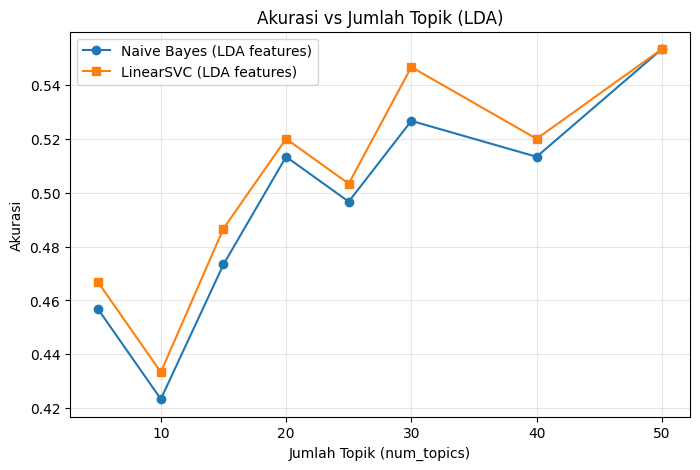

Best NB: topics=50 acc=0.5533
Best SVM: topics=50 acc=0.5533


In [7]:
# Sweep beberapa jumlah topik dan evaluasi akurasi
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Siapkan texts/labels dari _df yang sudah dibersihkan
texts_all = [doc.split() for doc in _df['clean'].tolist()]
y_all = _df['label'].astype(str).values

# Range jumlah topik (ubah sesuai kebutuhan)
topic_grid = [5, 10, 15, 20, 25, 30, 40, 50]

results_nb = []
results_svm = []

for k in topic_grid:
    # Kamus & korpus ulang agar sesuai filtering tiap k
    dictionary_k = corpora.Dictionary(texts_all)
    dictionary_k.filter_extremes(no_below=5, no_above=0.5)
    corpus_k = [dictionary_k.doc2bow(t) for t in texts_all]

    # Latih LDA untuk k topik
    lda_k = LdaModel(corpus=corpus_k, id2word=dictionary_k, num_topics=k, passes=5, random_state=42)

    # Dapatkan fitur distribusi topik
    def doc_topic_vec(bow):
        vec = np.zeros(k, dtype=np.float32)
        for tid, prob in lda_k.get_document_topics(bow, minimum_probability=0):
            vec[tid] = prob
        return vec

    X_k = np.vstack([doc_topic_vec(b) for b in corpus_k])

    # Split latih/uji konsisten
    Xtr, Xte, ytr, yte = train_test_split(X_k, y_all, test_size=0.2, random_state=42, stratify=y_all)

    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(Xtr, ytr)
    pred_nb = nb.predict(Xte)
    acc_nb = accuracy_score(yte, pred_nb)
    results_nb.append(acc_nb)

    # Linear SVM
    svm = LinearSVC(random_state=42)
    svm.fit(Xtr, ytr)
    pred_svm = svm.predict(Xte)
    acc_svm = accuracy_score(yte, pred_svm)
    results_svm.append(acc_svm)

# Plot hasil
plt.figure(figsize=(8,5))
plt.plot(topic_grid, results_nb, marker='o', label='Naive Bayes (LDA features)')
plt.plot(topic_grid, results_svm, marker='s', label='LinearSVC (LDA features)')
plt.xlabel('Jumlah Topik (num_topics)')
plt.ylabel('Akurasi')
plt.title('Akurasi vs Jumlah Topik (LDA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_nb_idx = int(np.argmax(results_nb))
best_svm_idx = int(np.argmax(results_svm))
print(f"Best NB: topics={topic_grid[best_nb_idx]} acc={results_nb[best_nb_idx]:.4f}")
print(f"Best SVM: topics={topic_grid[best_svm_idx]} acc={results_svm[best_svm_idx]:.4f}")



**Pelatihan dan Evaluasi Model di Fitur Topik**

Bagi data menjadi latih/uji, latih MultinomialNB dan LinearSVC, lalu tampilkan metrik akurasi dan classification report.


In [8]:
# Bagi data latih/uji secara stratified
X_train, X_test, y_train, y_test = train_test_split(
    X_topics, y, test_size=0.2, random_state=42, stratify=y
)

# Naive Bayes Multinomial cocok untuk fitur non-negatif (probabilitas topik memenuhi syarat)
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
nb_pred = nb_clf.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))

# LinearSVC di fitur probabilitas topik
svm_clf = LinearSVC(random_state=42)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))


Naive Bayes Accuracy: 0.5133333333333333
               precision    recall  f1-score   support

      Ekonomi       0.47      0.45      0.46        75
Internasional       0.68      0.57      0.62        75
     Nasional       0.36      0.40      0.38        75
     Olahraga       0.58      0.63      0.60        75

     accuracy                           0.51       300
    macro avg       0.52      0.51      0.52       300
 weighted avg       0.52      0.51      0.52       300

SVM Accuracy: 0.52
               precision    recall  f1-score   support

      Ekonomi       0.44      0.45      0.44        75
Internasional       0.70      0.59      0.64        75
     Nasional       0.37      0.37      0.37        75
     Olahraga       0.60      0.67      0.63        75

     accuracy                           0.52       300
    macro avg       0.53      0.52      0.52       300
 weighted avg       0.53      0.52      0.52       300



**Baseline: TF‑IDF + LinearSVC (SVM linear)**

Sebagai pembanding, menggunakan fitur TF‑IDF n‑gram dan model LinearSVC untuk klasifikasi teks.


In [9]:
# Baseline TF-IDF + LinearSVC
# Menggunakan representasi TF-IDF n-gram (1-2) yang umum kuat untuk klasifikasi teks berita
from sklearn.feature_extraction.text import TfidfVectorizer

# Bangun matriks TF-IDF dari teks yang sudah dibersihkan
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3)
X_tfidf = vectorizer.fit_transform(_df['clean'])

# Bagi data latih/uji yang konsisten dengan eksperimen LDA
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Latih LinearSVC pada fitur TF-IDF
svm_tfidf = LinearSVC(random_state=42)
svm_tfidf.fit(X_train2, y_train2)
svm_tfidf_pred = svm_tfidf.predict(X_test2)

# Tampilkan metrik akurasi dan laporan klasifikasi
print("TF-IDF LinearSVC Accuracy:", accuracy_score(y_test2, svm_tfidf_pred))
print(classification_report(y_test2, svm_tfidf_pred))


TF-IDF LinearSVC Accuracy: 0.8933333333333333
               precision    recall  f1-score   support

      Ekonomi       0.82      0.93      0.88        75
Internasional       0.95      0.95      0.95        75
     Nasional       0.84      0.79      0.81        75
     Olahraga       0.97      0.91      0.94        75

     accuracy                           0.89       300
    macro avg       0.90      0.89      0.89       300
 weighted avg       0.90      0.89      0.89       300



**Ringkasan Hasil**
- Akurasi Naive Bayes dan SVM pada fitur topik LDA moderat (sekitar 0.5 pada contoh output), menandakan representasi topik kurang diskriminatif untuk tugas klasifikasi kategori berita yang spesifik.
- Baseline TF‑IDF + LinearSVC menunjukkan akurasi jauh lebih tinggi (~0.89 pada contoh output), menegaskan bahwa representasi TF‑IDF efektif untuk teks berita.




# Clustering Spam Detection dengan K-Means

Notebook ini melakukan analisis clustering untuk deteksi spam menggunakan algoritma K-Means dengan berbagai teknik preprocessing dan evaluasi.

## Tujuan
- Melakukan clustering pada dataset teks untuk mengidentifikasi pola spam
- Mencari jumlah cluster optimal menggunakan silhouette score
- Membandingkan hasil clustering dengan ground truth (jika tersedia)
- Visualisasi hasil clustering dalam 2D menggunakan UMAP

## Metodologi
1. **Preprocessing**: Pembersihan teks, normalisasi, dan penghapusan stopwords
2. **Feature Extraction**: TF-IDF dengan n-gram (1,2) untuk ekstraksi fitur
3. **Dimensionality Reduction**: SVD (LSA) untuk mengurangi dimensi
4. **Clustering**: K-Means dengan grid search untuk mencari k optimal
5. **Evaluasi**: Silhouette score, NMI, dan ARI
6. **Visualisasi**: UMAP untuk proyeksi 2D


**Setup dan Instalasi Library**

Pada bagian ini, kita akan melakukan instalasi otomatis library yang diperlukan dan mengunduh data NLTK yang dibutuhkan.


In [10]:
# Setup yang dioptimasi (hanya install jika benar-benar diperlukan)
import sys, subprocess, importlib.util

# Daftar library yang diperlukan dengan nama package dan module
reqs = [
    ("pandas","pandas"), ("numpy","numpy"), ("scikit-learn","sklearn"),
    ("nltk","nltk"), ("matplotlib","matplotlib"), ("tqdm","tqdm")
    # Hapus umap, seaborn, numba, llvmlite untuk menghindari dependency yang berat
]

# Cek library mana yang belum terinstall
missing = [p for p,m in reqs if importlib.util.find_spec(m) is None]

# Hanya install jika ada yang missing (tidak setiap kali dijalankan)
if missing:
    print(f"Installing missing packages: {missing}")
    # Install library yang missing dengan prefer binary untuk kecepatan
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--prefer-binary", *missing])
else:
    print("All required packages already installed.")

# Download stopwords NLTK jika belum ada (lebih cepat)
import nltk
try:
    from nltk.corpus import stopwords
    _ = stopwords.words('english')
    print("NLTK stopwords ready.")
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords', quiet=True)
    print("NLTK stopwords downloaded.")

print("✅ Setup complete - Optimized version!")


All required packages already installed.
NLTK stopwords ready.
✅ Setup complete - Optimized version!


**Import Library dan Konfigurasi**

Import semua library yang diperlukan untuk analisis clustering dan konfigurasi environment.


In [11]:
# Import library sistem dan konfigurasi - VERSI OPTIMASI
import os, re, warnings
warnings.filterwarnings('ignore')  # Menyembunyikan warning untuk output yang bersih

# Import library untuk manipulasi data (ringan dan cepat)
import numpy as np  # Komputasi numerik
import pandas as pd  # Manipulasi data tabular
from tqdm import tqdm  # Progress bar untuk iterasi

# Import library untuk visualisasi (hanya yang diperlukan)
import matplotlib.pyplot as plt  # Plotting dasar
# Hapus seaborn karena lambat untuk dataset besar

# Import NLTK untuk pemrosesan bahasa alami (sudah di-download di setup)
from nltk.corpus import stopwords  # Stopwords untuk preprocessing teks

# Import scikit-learn untuk machine learning (ringan dan cepat)
from sklearn.feature_extraction.text import TfidfVectorizer  # Ekstraksi fitur TF-IDF
from sklearn.decomposition import TruncatedSVD  # Dimensionality reduction dengan SVD
from sklearn.preprocessing import Normalizer  # Normalisasi data
from sklearn.pipeline import make_pipeline  # Pipeline untuk menggabungkan preprocessing steps
from sklearn.cluster import KMeans  # Algoritma clustering K-Means
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score  # Metrik evaluasi clustering

# Import alternatif untuk visualisasi (lebih cepat dari UMAP)
from sklearn.decomposition import PCA  # PCA sebagai alternatif UMAP yang lebih cepat

print("✅ Library import complete - Optimized for speed!")


✅ Library import complete - Optimized for speed!


**Load Dataset**

Memuat dataset dari file CSV dengan penanganan berbagai encoding untuk memastikan kompatibilitas.


In [12]:
# Load dataset dari file CSV
csv_path = "spam.csv"  # Path ke file dataset

def try_read_csv(path):
    """
    Fungsi untuk membaca CSV dengan berbagai encoding
    Mencoba beberapa encoding umum untuk menangani file dengan encoding berbeda
    """
    # Daftar encoding yang umum digunakan
    encodings = ["utf-8", "latin1", "cp1252", "iso-8859-1"]
    
    # Coba setiap encoding sampai berhasil
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e  # Simpan error terakhir jika semua gagal
    raise last_err  # Raise error jika semua encoding gagal

# Load dataset dengan fungsi yang sudah dibuat
raw = try_read_csv(csv_path)

# Tampilkan informasi dasar dataset
print(f"Shape dataset: {raw.shape}")  # Menampilkan jumlah baris dan kolom
print("5 baris pertama dataset:")
raw.head()


Shape dataset: (5572, 5)
5 baris pertama dataset:


,id,Text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,1,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,2,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,3,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,4,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,5,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Deteksi Kolom Teks dan Label**

Mengidentifikasi kolom yang berisi teks dan label secara otomatis berdasarkan nama kolom.


In [13]:
# Deteksi kolom teks dan label secara otomatis
# Konversi nama kolom ke lowercase untuk pencarian yang case-insensitive
cols_lower = [c.lower() for c in raw.columns]
col_map = {c.lower(): c for c in raw.columns}  # Mapping untuk mendapatkan nama kolom asli

# Cari kolom yang kemungkinan berisi teks berdasarkan kata kunci
text_candidates = [c for c in cols_lower if any(k in c for k in ["text","message","email","content","body","teks","berita","pesan"])]
# Cari kolom yang kemungkinan berisi label berdasarkan kata kunci
label_candidates = [c for c in cols_lower if any(k in c for k in ["label","spam","class","kategori","target"]) ]

# Pilih kolom pertama yang cocok, atau kolom pertama jika tidak ada yang cocok
text_col = col_map[text_candidates[0]] if text_candidates else raw.columns[0]
label_col = col_map[label_candidates[0]] if label_candidates else None

# Tampilkan kolom yang terdeteksi
print(f"Text column: {text_col}")
print(f"Label column: {label_col}")

# Buat dataframe baru dengan hanya kolom yang diperlukan
df = raw[[text_col] + ([label_col] if label_col else [])].copy()

# Rename kolom untuk konsistensi
df = df.rename(columns={
    text_col: "text", 
    (label_col if label_col else text_col): ("label" if label_col else "text")
})

# Hapus baris dengan teks kosong atau NaN
df = df.dropna(subset=["text"]) 

# Tampilkan informasi dataset setelah preprocessing
print(f"Shape dataset setelah preprocessing: {df.shape}")
print("5 baris pertama dataset:")
df.head()


Text column: Text
Label column: None
Shape dataset setelah preprocessing: (5572, 1)
5 baris pertama dataset:


,text
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."


**Preprocessing dan Normalisasi Teks**

Membersihkan dan menormalisasi teks dengan menghapus stopwords, tokenisasi, dan filtering kata.


In [14]:
# Normalisasi dan preprocessing teks
# Pastikan stopwords sudah terdownload
try:
    _ = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Load stopwords dalam bahasa Inggris dan Indonesia
eng_stop = set(stopwords.words('english'))  # Stopwords bahasa Inggris
indo_stop = set(stopwords.words('indonesian')) if 'indonesian' in stopwords.fileids() else set()  # Stopwords bahasa Indonesia (jika tersedia)

# Gabungkan stopwords dengan kata-kata umum yang sering muncul di media sosial
common_stops = eng_stop | indo_stop | {"rt","amp","via"}

# Regex pattern untuk mengekstrak hanya kata yang terdiri dari huruf (A-Z, a-z)
TOKEN_RE = re.compile(r"[A-Za-z]+")

def normalize(text):
    """
    Fungsi untuk menormalisasi teks:
    1. Konversi ke lowercase
    2. Tokenisasi menggunakan regex
    3. Hapus stopwords dan kata pendek (< 3 karakter)
    4. Join kembali menjadi string
    """
    text = str(text).lower()  # Konversi ke huruf kecil
    tokens = TOKEN_RE.findall(text)  # Ekstrak token yang hanya berisi huruf
    # Filter token: hapus stopwords dan kata dengan panjang < 3 karakter
    tokens = [t for t in tokens if t not in common_stops and len(t) > 2]
    return " ".join(tokens)  # Gabungkan kembali menjadi string

# Terapkan normalisasi ke semua teks
df['clean'] = df['text'].map(normalize)

# Hapus baris dengan teks kosong setelah preprocessing
df = df[df['clean'].str.strip().astype(bool)]

# Tampilkan hasil preprocessing
print(f"Shape dataset setelah normalisasi: {df.shape}")
print("Contoh teks asli dan hasil normalisasi:")
df[['text','clean']].head(10)


Shape dataset setelah normalisasi: (5531, 2)
Contoh teks asli dan hasil normalisasi:


,text,clean
0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,Ok lar... Joking wif u oni...,lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...
3,U dun say so early hor... U c already then say...,dun say early hor already say
4,"Nah I don't think he goes to usf, he lives aro...",think goes usf lives around though
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling week word back like fun st...
6,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,As per your request 'Melle Melle (Oru Minnamin...,request melle melle oru minnaminunginte nurung...
8,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,Had your mobile 11 months or more? U R entitle...,mobile months entitled update latest colour mo...


**Ekstraksi Fitur dengan TF-IDF dan Dimensionality Reduction**

Menggunakan TF-IDF untuk mengubah teks menjadi vektor numerik dan SVD untuk mengurangi dimensi.


In [15]:
# Ekstraksi fitur dengan TF-IDF dan dimensionality reduction dengan SVD (LSA)
# TF-IDF Vectorizer: mengubah teks menjadi vektor numerik
vectorizer = TfidfVectorizer(
    max_features=30000,  # Maksimal 30,000 fitur (kata) yang paling penting
    ngram_range=(1,2),   # Gunakan unigram (1 kata) dan bigram (2 kata)
    min_df=3            # Kata harus muncul minimal 3 kali di seluruh dokumen
)
X_tfidf = vectorizer.fit_transform(df['clean'])  # Transform teks ke matriks TF-IDF
print(f"Shape TF-IDF matrix: {X_tfidf.shape}")

# Dimensionality reduction dengan SVD (Singular Value Decomposition)
# Juga dikenal sebagai Latent Semantic Analysis (LSA)
svd = TruncatedSVD(
    n_components=100,  # Kurangi ke 100 komponen utama
    random_state=42    # Seed untuk reproduktibilitas
)
normalizer = Normalizer(copy=False)  # Normalisasi vektor ke unit length

# Gabungkan SVD dan normalizer dalam pipeline
lsa = make_pipeline(svd, normalizer)

# Terapkan dimensionality reduction ke TF-IDF matrix
X = lsa.fit_transform(X_tfidf)

print(f"Shape setelah dimensionality reduction: {X.shape}")
print(f"Variance explained ratio: {svd.explained_variance_ratio_.sum():.4f}")


Shape TF-IDF matrix: (5531, 4219)
Shape setelah dimensionality reduction: (5531, 100)
Variance explained ratio: 0.2504


**Grid Search untuk Mencari Jumlah Cluster Optimal**

Menggunakan silhouette score untuk menentukan jumlah cluster optimal dengan K-Means.


In [16]:
# Grid search untuk mencari jumlah cluster optimal menggunakan silhouette score
k_values = list(range(2, 11))  # Test dari 2 sampai 10 cluster
results = []  # List untuk menyimpan hasil evaluasi
models = {}   # Dictionary untuk menyimpan model dan label hasil clustering

print("Melakukan grid search untuk mencari k optimal...")
print("k\tsilhouette_score")
print("-" * 20)

# Loop untuk setiap nilai k
for k in k_values:
    # Inisialisasi K-Means dengan k cluster
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    
    # Fit model dan predict cluster labels
    labels = km.fit_predict(X)
    
    # Hitung silhouette score untuk evaluasi kualitas clustering
    sil = silhouette_score(X, labels)
    
    # Simpan hasil
    results.append({"k": k, "silhouette": sil})
    models[k] = (km, labels)  # Simpan model dan labels
    
    # Tampilkan hasil
    print(f"{k}\t{sil:.4f}")

# Konversi hasil ke DataFrame untuk analisis
res_df = pd.DataFrame(results)

# Cari k dengan silhouette score tertinggi
best_row = res_df.loc[res_df['silhouette'].idxmax()]
best_k = int(best_row['k'])

print(f"\nBest k berdasarkan silhouette score: {best_k}")
print(f"Silhouette score terbaik: {best_row['silhouette']:.4f}")

# Ambil model dan labels terbaik
best_model, best_labels = models[best_k]

# Tampilkan tabel hasil
print("\nTabel hasil evaluasi:")
res_df


Melakukan grid search untuk mencari k optimal...
k	silhouette_score
--------------------
2	0.0215
3	0.0231
4	0.0248
5	0.0293
6	0.0350
7	0.0389
8	0.0440
9	0.0479
10	0.0502

Best k berdasarkan silhouette score: 10
Silhouette score terbaik: 0.0502

Tabel hasil evaluasi:


,k,silhouette
0,2,0.021549
1,3,0.023110
2,4,0.024820
3,5,0.029266
4,6,0.034972
5,7,0.038888
6,8,0.044001
7,9,0.047879
8,10,0.050234


**Evaluasi dan Visualisasi Hasil Clustering**

Evaluasi clustering dengan metrik eksternal (jika ada ground truth) dan visualisasi menggunakan UMAP.


Ground truth labels tidak ditemukan; hanya melaporkan silhouette score.

Membuat visualisasi 2D dengan PCA (lebih cepat dari UMAP)...
Variance explained by PCA: 0.0447

Jumlah cluster yang terbentuk: 10
Cluster 0: 488 dokumen (8.8%)
Cluster 1: 184 dokumen (3.3%)
Cluster 2: 382 dokumen (6.9%)
Cluster 3: 214 dokumen (3.9%)
Cluster 4: 172 dokumen (3.1%)
Cluster 5: 445 dokumen (8.0%)
Cluster 6: 372 dokumen (6.7%)
Cluster 7: 2214 dokumen (40.0%)
Cluster 8: 145 dokumen (2.6%)
Cluster 9: 915 dokumen (16.5%)


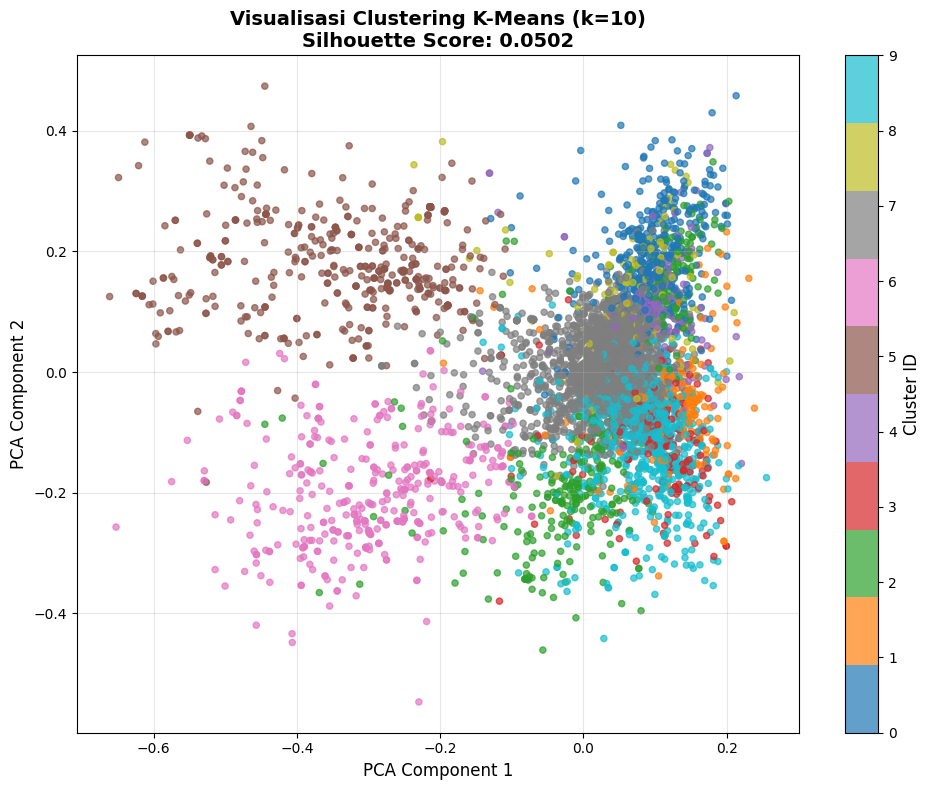

In [17]:
# Evaluasi clustering dengan metrik eksternal (jika ada ground truth)
if 'label' in df.columns:
    # Jika ada label asli (ground truth), hitung metrik eksternal
    true_labels = df['label'].astype(str).values
    
    # Normalized Mutual Information (NMI): mengukur kesamaan informasi antara clustering dan ground truth
    nmi = normalized_mutual_info_score(true_labels, best_labels)
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    
    # Adjusted Rand Index (ARI): mengukur kesamaan clustering dengan ground truth (0-1, 1 = perfect match)
    ari = adjusted_rand_score(true_labels, best_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    
    print(f"\nInterpretasi:")
    print(f"- NMI > 0.5: clustering yang baik")
    print(f"- ARI > 0.3: clustering yang cukup baik")
    print(f"- ARI > 0.5: clustering yang sangat baik")
    
else:
    print("Ground truth labels tidak ditemukan; hanya melaporkan silhouette score.")

# Visualisasi clustering dalam 2D menggunakan PCA (lebih cepat dari UMAP)
print(f"\nMembuat visualisasi 2D dengan PCA (lebih cepat dari UMAP)...")

# Reduksi dimensi ke 2D untuk visualisasi menggunakan PCA
reducer = PCA(
    n_components=2,    # Reduksi ke 2 dimensi untuk plotting
    random_state=42    # Seed untuk reproduktibilitas
)
X_2d = reducer.fit_transform(X)

print(f"Variance explained by PCA: {reducer.explained_variance_ratio_.sum():.4f}")

# Plot hasil clustering
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1], 
    c=best_labels,           # Warna berdasarkan cluster
    cmap='tab10',           # Colormap dengan 10 warna berbeda
    s=20,                   # Ukuran titik
    alpha=0.7               # Transparansi
)

plt.title(f"Visualisasi Clustering K-Means (k={best_k})\nSilhouette Score: {best_row['silhouette']:.4f}", 
          fontsize=14, fontweight='bold')
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)

# Tambahkan colorbar dengan label
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster ID', fontsize=12)

# Tambahkan grid untuk kemudahan membaca
plt.grid(True, alpha=0.3)

# Tampilkan informasi cluster
unique_labels = np.unique(best_labels)
print(f"\nJumlah cluster yang terbentuk: {len(unique_labels)}")
for label in unique_labels:
    count = np.sum(best_labels == label)
    percentage = (count / len(best_labels)) * 100
    print(f"Cluster {label}: {count} dokumen ({percentage:.1f}%)")

plt.tight_layout()
plt.show()
